<a href="https://colab.research.google.com/github/alekrul/gt-health-management/blob/main/ProDiMES_with_GridSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

In [2]:
!pip install scikeras
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 90.8 MB/s eta 0:00:00


In [3]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, roc_auc_score, precision_score, recall_score, f1_score

sns.set()

ImportError: cannot import name '_add_to_diagonal' from 'sklearn.utils._array_api' (/usr/local/lib/python3.11/dist-packages/sklearn/utils/_array_api.py)

##Read data

In [ ]:
filename = 'data.mat'

location = "/content/drive/MyDrive/Mestrado/Condition Based HM/ProDiMES/"

file_path = location + filename

In [ ]:
data = loadmat(file_path)

efs_output_c = data['efs_output_c']
efs_output_to = data['efs_output_to']
engine_params = data['engine_params']
fault_params = data['fault_params']
sensor_noise = data['sensor_noise']

In [ ]:
engines, flights, variables = efs_output_c.shape

efs_output_c_flat = efs_output_c.reshape(engines * flights, variables)

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_c","Nc_c","P24_c","Ps30_c","T24_c","T30_c","T48_c","Wf_c","P2_c","T2_c","Pamb_c"]
data = np.column_stack((engine_ids, flight_ids, efs_output_c_flat))
efs_output_c_df = pd.DataFrame(data, columns=column_names)

In [ ]:
efs_output_c_df.head()

In [ ]:
engines, flights, variables = efs_output_to.shape

efs_output_to_flat = efs_output_to.reshape(engines * flights, variables)

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_to","Nc_to","P24_to","Ps30_to","T24_to","T30_to","T48_to","Wf_to","P2_to","T2_to","Pamb_to"]
data = np.column_stack((engine_ids, flight_ids, efs_output_to_flat))
efs_output_to_df = pd.DataFrame(data, columns=column_names)

In [ ]:
efs_output_to_df.head()

In [ ]:
engines, flights, params = engine_params.shape

engine_params_flat = engine_params.reshape(engines * flights, params)

engine_params_columns = ["engine", "flight","altitude_to","mach_to","dTamb_to","NfR_to","altitude_c","mach_c",
                         "dTamb_c","Fn_c","fan_eff","fan_fc","lpc_eff","lpc_fc","hpc_eff","hpc_fc",
                         "hpt_eff","hpt_fc","lpt_eff","lpt_fc"]

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

data = np.column_stack((engine_ids, flight_ids, engine_params_flat))
engine_params_df = pd.DataFrame(data, columns=engine_params_columns)

In [ ]:
engine_params_df.head()

In [ ]:
fault_params_df = pd.DataFrame(fault_params, columns=["fault_id","fligh_initiation","fault_ev_rate","fault_magnitude","fc_eff_ratio"])

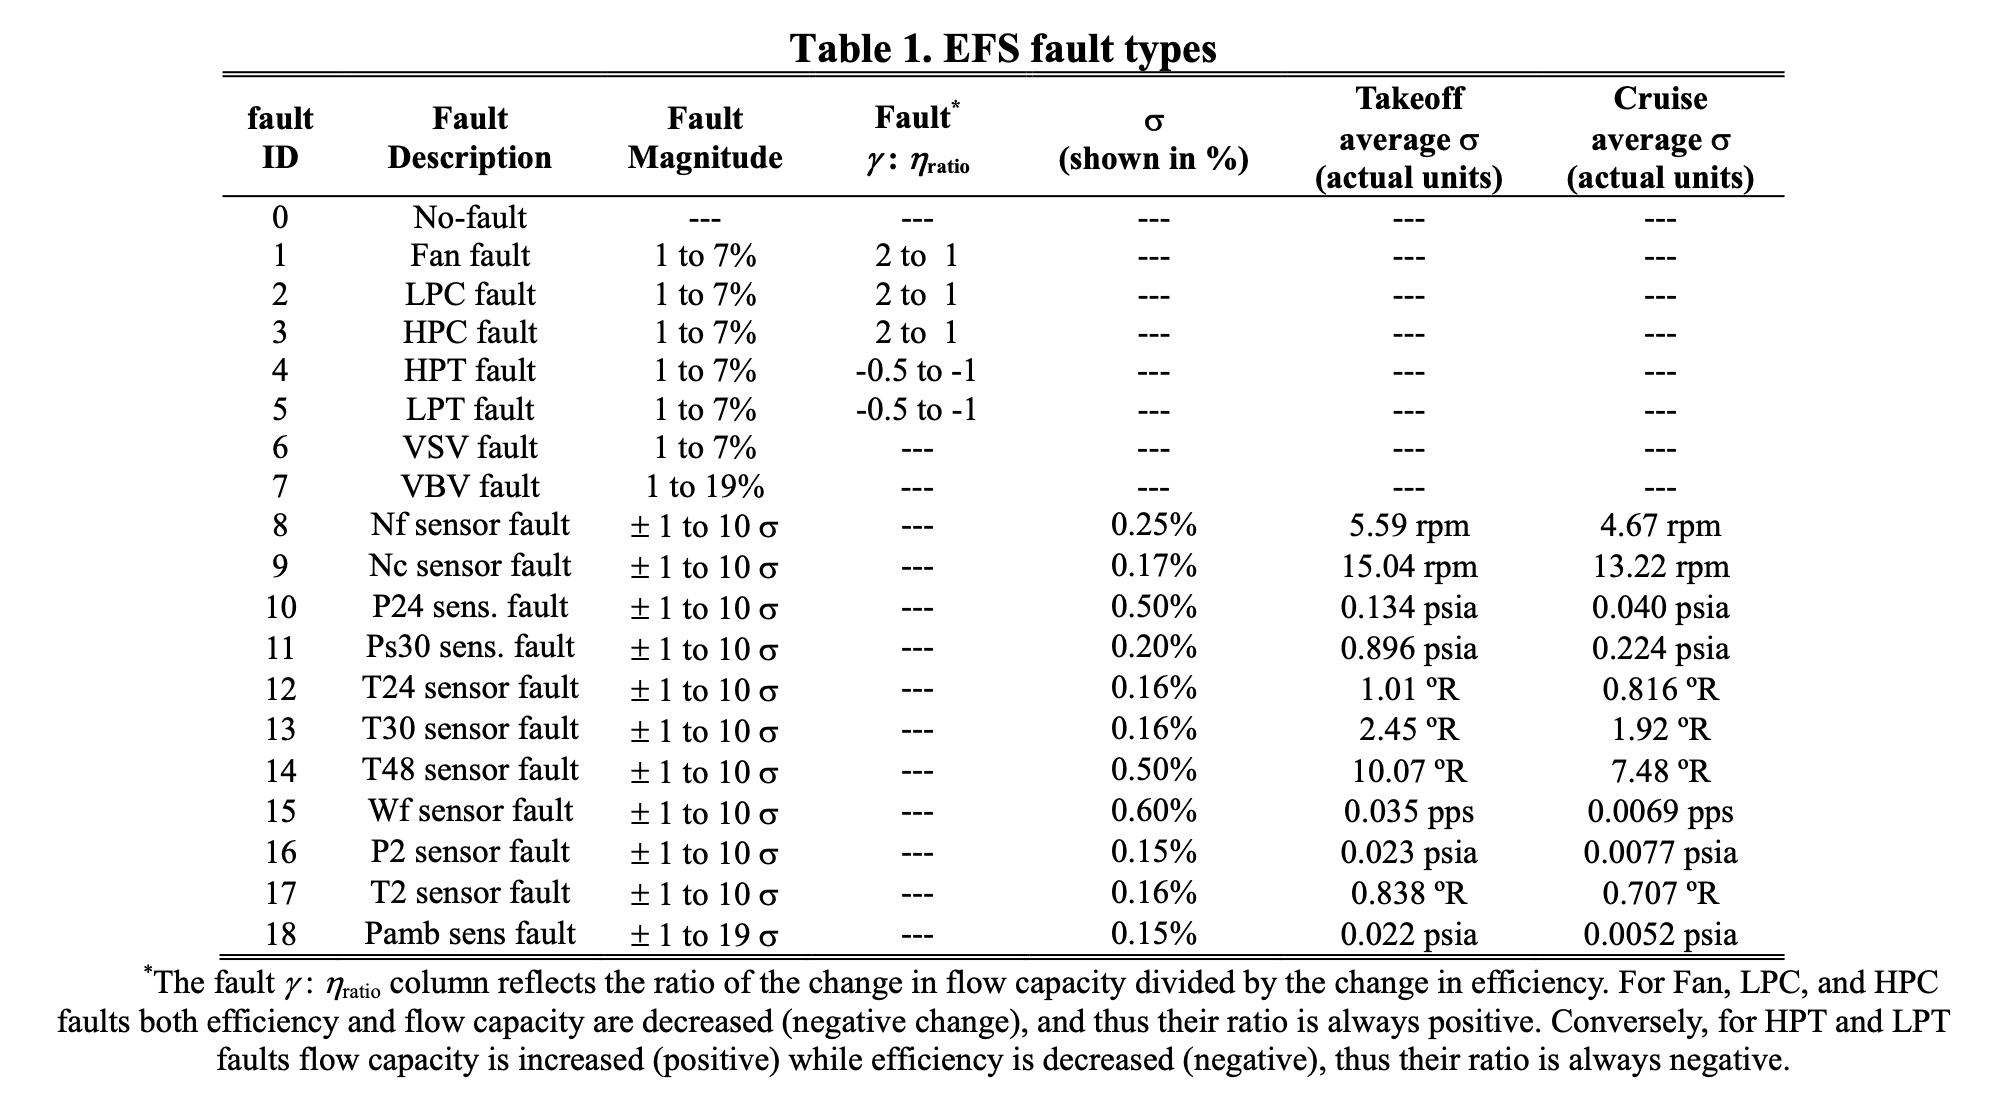

In [ ]:
fault_params_df = fault_params_df.rename_axis("engine")

In [ ]:
fault_params_df.head()

## Visualize Data

In [ ]:
def visualize_param(dataset,engine, ysensor,xsensor):
  y_values = dataset[dataset['engine'] == engine][[ysensor]]
  x_values = dataset[dataset['engine'] == engine][[xsensor]]

  plt.figure(figsize=(8, 6))  # Set the figure size
  plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', label=y_values.columns[0]+' vs. '+x_values.columns[0])
  plt.xlabel(x_values.columns[0])
  plt.ylabel(y_values.columns[0])
  plt.title(label=y_values.columns[0]+' vs. '+x_values.columns[0])
  plt.legend()
  plt.grid(True)

In [ ]:
visualize_param(efs_output_c_df,88,"T48_c","flight")

In [ ]:
def scatter_values(dataset, engines, ysensor, xsensor, fault_df=fault_params_df):
    fault_df = fault_df.reset_index()

    subset = dataset[dataset['engine'].isin(engines)]

    subset = subset.merge(fault_df[['engine', 'fault_id']], on='engine', how='left')

    fault_ids = subset['fault_id'].unique()
    colors = plt.cm.tab10(range(len(fault_ids)))
    fault_colors = {fault_id: colors[i] for i, fault_id in enumerate(fault_ids)}

    plt.figure(figsize=(10, 7))
    for fault_id, color in fault_colors.items():
        fault_subset = subset[subset['fault_id'] == fault_id]
        plt.scatter(
            fault_subset[xsensor], fault_subset[ysensor],
            color=color, label=f'Fault ID {fault_id}', alpha=0.8
        )

    plt.xlabel(xsensor)
    plt.ylabel(ysensor)
    plt.title(f'{ysensor} vs. {xsensor} by Fault Type')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
faults = [0,4]
engines = fault_params_df[fault_params_df["fault_id"].isin(faults)].index

scatter_values(efs_output_c_df,engines,"T48_c","Wf_c",fault_params_df)

##Data pre-processing

###Baseline

Tentar de dois jeitos:
1. interpolação com dados gerados pelo CMAPSS-SS
2. Rede Neural que faz a estimativa

1. Interpolação com dados gerados pelo CMAPSS-SS

In [ ]:
file1 = 'EFS_fault_conditions_health.mat'
file2 = 'EFS_operating_conditions_health.mat'
file3 = 'EFS_Output_health.mat'

location = "/content/drive/MyDrive/Mestrado/Condition Based HM/ProDiMES/"

file_path1 = location + file1
file_path2 = location + file2
file_path3 = location + file3

data1 = loadmat(file_path1)
data2 = loadmat(file_path2)
data3 = loadmat(file_path3)

health_efs_output_c = data3['efs_output_c']
health_efs_output_to = data3['efs_output_to']
health_engine_params = data2['engine_params']
health_fault_params = data1['fault_params']
health_sensor_noise = data2['sensor_noise']

In [ ]:
health_efs_output_c.shape

In [ ]:
engines, flights, variables = health_efs_output_c.shape

health_efs_output_c_flat = health_efs_output_c.reshape(engines * flights, variables)

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_c","Nc_c","P24_c","Ps30_c","T24_c","T30_c","T48_c","Wf_c","P2_c","T2_c","Pamb_c"]
data = np.column_stack((engine_ids, flight_ids, health_efs_output_c_flat))
health_efs_output_c_df = pd.DataFrame(data, columns=column_names)

In [ ]:
engines, flights, variables = health_efs_output_to.shape

health_efs_output_to_flat = health_efs_output_to.reshape(engines * flights, variables)

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_to","Nc_to","P24_to","Ps30_to","T24_to","T30_to","T48_to","Wf_to","P2_to","T2_to","Pamb_to"]
data = np.column_stack((engine_ids, flight_ids, health_efs_output_to_flat))
health_efs_output_to_df = pd.DataFrame(data, columns=column_names)

In [ ]:
engines, flights, params = health_engine_params.shape

health_engine_params_flat = health_engine_params.reshape(engines * flights, params)

health_engine_params_columns = ["engine", "flight","altitude_to","mach_to","dTamb_to","NfR_to","altitude_c","mach_c",
                         "dTamb_c","Fn_c","fan_eff","fan_fc","lpc_eff","lpc_fc","hpc_eff","hpc_fc",
                         "hpt_eff","hpt_fc","lpt_eff","lpt_fc"]

engine_ids = np.repeat(np.arange(1, engines + 1), flights)
flight_ids = np.tile(np.arange(1, flights + 1), engines)

data = np.column_stack((engine_ids, flight_ids, health_engine_params_flat))
health_engine_params_df = pd.DataFrame(data, columns=health_engine_params_columns)

In [ ]:
u_to = health_engine_params_df[["altitude_to","mach_to","dTamb_to","NfR_to"]]
u_c = health_engine_params_df[["altitude_c","mach_c","dTamb_c","Fn_c"]]

In [ ]:
y_to = health_efs_output_to_df.drop(columns=["engine","flight"])
y_c =  health_efs_output_c_df.drop(columns=["engine","flight"])

In [ ]:
y_to.head()

In [ ]:
models_to = {}
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)

for column in y_to.columns:
    pipeline = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression())
    ])

    pipeline.fit(u_to, y_to[column])

    models_to[column] = pipeline


In [ ]:
models_c = {}
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)

for column in y_c.columns:
    pipeline = Pipeline([
        ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
        ("lin_reg", LinearRegression())
    ])

    pipeline.fit(u_c, y_c[column])

    models_c[column] = pipeline

In [ ]:
#estimating the parameters from the health dataset to evaluate model

health_y_to_model = {}
for column, model in models_to.items():
    health_y_to_model[column] = model.predict(u_to)

health_y_c_model = {}
for column, model in models_c.items():
    health_y_c_model[column] = model.predict(u_c)

health_y_to_model_df = pd.DataFrame(health_y_to_model)
health_y_c_model_df = pd.DataFrame(health_y_c_model)

In [ ]:
#now estimate for the parameters of the original dataset
u_orig_to = engine_params_df[["altitude_to","mach_to","dTamb_to","NfR_to"]]
u_orig_c = engine_params_df[["altitude_c","mach_c","dTamb_c","Fn_c"]]

health_y_to = {}
for column, model in models_to.items():
    health_y_to[column] = model.predict(u_orig_to)

health_y_c = {}
for column, model in models_c.items():
    health_y_c[column] = model.predict(u_orig_c)

health_y_to_df = pd.DataFrame(health_y_to)
health_y_c_df = pd.DataFrame(health_y_c)

In [ ]:
health_y_to_df.head()

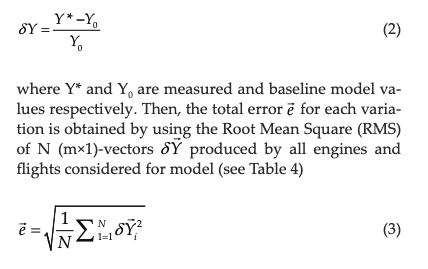

In [ ]:
def calculate_rmse(y_true, y_pred):
    return np.sqrt(np.mean(((y_true - y_pred)/y_pred) ** 2))

rmse_to = {col: calculate_rmse(y_to[col].values, health_y_to_model_df[col].values) for col in y_to.columns}
rmse_to["Mean"] = np.mean(list(rmse_to.values()))

rmse_c = {col: calculate_rmse(y_c[col].values, health_y_c_model_df[col].values) for col in y_c.columns}
rmse_c["Mean"] = np.mean(list(rmse_c.values()))

rmse_df = pd.DataFrame([rmse_to, rmse_c], index=["Takeoff Model", "Cruise Model"])

In [ ]:
rmse_df.head()

In [ ]:
# Separar colunas que terminam com '_to'
rmse_to_df = rmse_df[[col for col in rmse_df.columns if '_to' in col] + ['Mean']]

# Separar colunas que terminam com '_c'
rmse_c_df = rmse_df[[col for col in rmse_df.columns if '_c' in col] + ['Mean']]

# Exibir os DataFrames separados
print("### RMSE Takeoff Model ###")
print(rmse_to_df.to_string())

print("\n### RMSE Cruise Model ###")
print(rmse_c_df.to_string())

In [ ]:
deviation_to = {}
for column in efs_output_to_df.columns[2:]:
  deviation_to[column] = (efs_output_to_df[column] - health_y_to_df[column])/health_y_to_df[column]

deviation_c = {}
for column in efs_output_c_df.columns[2:]:
  deviation_c[column] = (efs_output_c_df[column] - health_y_c_df[column])/health_y_c_df[column]


deviation_to_df = pd.DataFrame(deviation_to)
deviation_c_df = pd.DataFrame(deviation_c)

In [ ]:
deviation_c_df["engine"] = efs_output_c_df["engine"]
deviation_c_df["flight"] = efs_output_c_df["flight"]

In [ ]:
deviation_to_df["engine"] = efs_output_to_df["engine"]
deviation_to_df["flight"] = efs_output_to_df["flight"]

In [ ]:
visualize_param(deviation_c_df,442,"T48_c","flight")

In [ ]:
#note that for first 10 flights (health engine) deviation is higher than 0.
#Next step is to adjust the general model to consider specific engine characteristics

#first 10 flights are healthy conditions
def calculate_average_deviation(deviation_df):
    average_deviation = (
        deviation_df.groupby('engine')
        .apply(lambda group: group.iloc[:10, :-2].mean())
        .reset_index()
    )
    return average_deviation

average_deviation_to_df = calculate_average_deviation(deviation_to_df)
average_deviation_c_df = calculate_average_deviation(deviation_c_df)

In [ ]:
average_deviation_c_df.head()

In [ ]:
health_y_c_df["flight"] = efs_output_c_df["flight"]
health_y_c_df["engine"] = efs_output_c_df["engine"]

health_y_to_df["flight"] = efs_output_to_df["flight"]
health_y_to_df["engine"] = efs_output_to_df["engine"]

In [ ]:
def update_health_conditions(health_y_df, avg_deviation_df, deviation_columns):
    updated_health_y_df = health_y_df.copy()

    for engine in avg_deviation_df['engine']:

        engine_avg_deviation = avg_deviation_df[avg_deviation_df['engine'] == engine][deviation_columns].iloc[0]

        engine_mask = (health_y_df['engine'] == engine)
        for column in deviation_columns:
            updated_health_y_df.loc[engine_mask, column] *= (1 + engine_avg_deviation[column])

    return updated_health_y_df

updated_health_y_to_df = update_health_conditions(health_y_to_df, average_deviation_to_df, health_y_to_df.drop(columns=["engine","flight"]).columns)
updated_health_y_c_df = update_health_conditions(health_y_c_df, average_deviation_c_df, health_y_c_df.drop(columns=["engine","flight"]).columns)

In [ ]:
updated_health_y_to_df.head()

In [ ]:
def calculate_final_deviations(observed_df, updated_health_y_df, deviation_columns):
    final_deviation_df = pd.DataFrame()
    for column in deviation_columns:
        final_deviation_df[column] = (observed_df[column] - updated_health_y_df[column]) / updated_health_y_df[column]
    return final_deviation_df

final_deviation_to_df = calculate_final_deviations(efs_output_to_df, updated_health_y_to_df, health_y_to_df.drop(columns=["engine","flight"]).columns)
final_deviation_c_df = calculate_final_deviations(efs_output_c_df, updated_health_y_c_df, health_y_c_df.drop(columns=["engine","flight"]).columns)


In [ ]:
final_deviation_to_df["engine"] = efs_output_to_df["engine"]
final_deviation_to_df["flight"] = efs_output_to_df["flight"]

final_deviation_c_df["engine"] = efs_output_c_df["engine"]
final_deviation_c_df["flight"] = efs_output_c_df["flight"]

In [ ]:
visualize_param(final_deviation_c_df,442,"T48_c","flight")

2. Rede Neural (TBD)

In [ ]:
#TBD

###Trend Monitoring

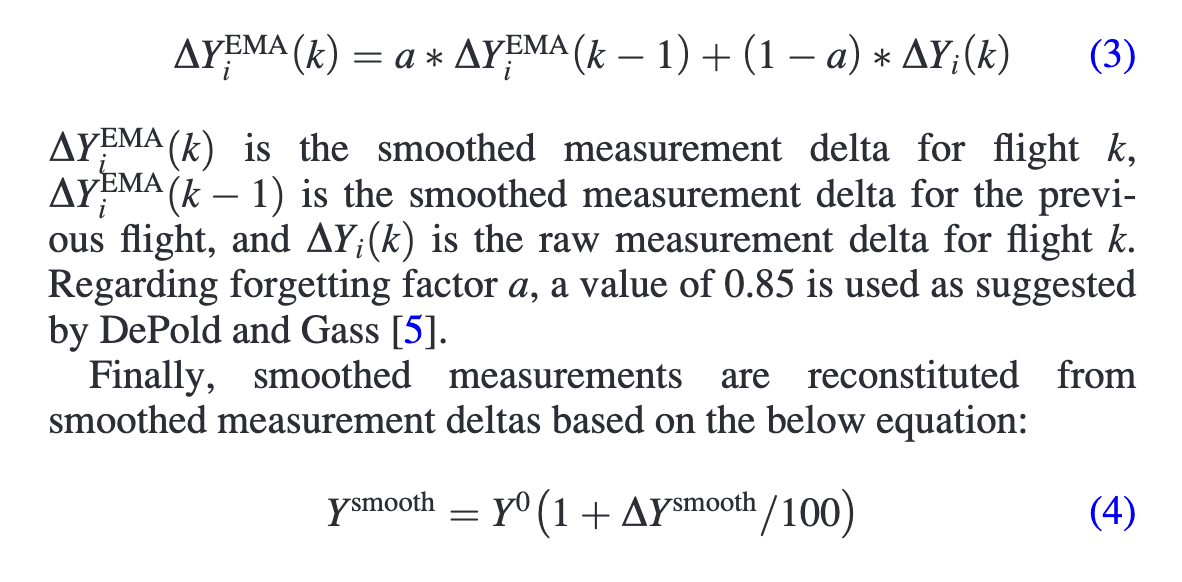

In [ ]:
#implement exponential moving average to smooth data
alpha = 0.85 #prodimes user guide uses 0.8844
def apply_exponential_moving_average(df, alpha, deviation_columns):
  ema_data = df[['engine', 'flight']].copy()

  for column in deviation_columns:
      if column not in df.columns:
          raise KeyError(f"Column '{column}' not found in the DataFrame!")

      ema_values = []

      for engine_id in df['engine'].unique():

          engine_data = df[df['engine'] == engine_id]

          if engine_data.empty:
              print(f"Warning: No data found for engine {engine_id}.")
              continue

          ema = engine_data[column].iloc[0]
          ema_values_engine = [ema]

          for k in range(1, len(engine_data)):
              delta_y = engine_data[column].iloc[k]
              ema = alpha * ema + (1 - alpha) * delta_y
              ema_values_engine.append(ema)

          ema_values.extend(ema_values_engine)

      ema_data[f'{column}_ema'] = ema_values

  return ema_data

deviation_columns_to = final_deviation_to_df.drop(columns=['engine', 'flight']).columns

deviation_columns_c = final_deviation_c_df.drop(columns=['engine', 'flight']).columns

ema_health_y_to_df = apply_exponential_moving_average(final_deviation_to_df, alpha, deviation_columns_to)
ema_health_y_c_df = apply_exponential_moving_average(final_deviation_c_df, alpha, deviation_columns_c)

In [ ]:
visualize_param(ema_health_y_c_df,442,"T48_c_ema","flight")

In [ ]:
faults = [0,18]
engines = fault_params_df[fault_params_df["fault_id"].isin(faults)].index

scatter_values(final_deviation_c_df.query('flight > 45'),engines,"T48_c","Wf_c",fault_params_df)

## Fault Identification & Classification

###Training and validation data treatment

In [ ]:
#testing without take off data
#data_total = pd.merge(ema_health_y_to_df, ema_health_y_c_df, on=['engine', 'flight'])
data_total = ema_health_y_c_df

In [ ]:
data_total.head()

In [ ]:
def createlabel(df,fault_param):
  label = {}
  for engine in df['engine'].unique():
    if engine not in fault_param.index:
      print(f"Warning: Engine {engine} not found in fault_param. Skipping.")
      continue  # Skip engines that are not in fault_param
    flight_init = fault_param.loc[engine]['fligh_initiation']
    fault_id = fault_param.loc[engine]['fault_id']

    for flight in df[df['engine'] == engine]['flight']:
      if flight < flight_init:
        label[(engine,flight)] = 0
      else:
        label[(engine,flight)] = fault_id
  return label


In [ ]:
fault_label = createlabel(data_total,fault_params_df)

In [ ]:
fault_label_df = (
    pd.DataFrame.from_dict(fault_label, orient='index', columns=['fault_label'])
    .reset_index()
)
fault_label_df[['engine', 'flight']] = pd.DataFrame(fault_label_df['index'].tolist(), index=fault_label_df.index)
fault_label_df = fault_label_df.drop(columns=['index'])

data_total_with_labels = pd.merge(data_total, fault_label_df, on=['engine', 'flight'], how='left')

In [ ]:
data_total_with_labels.head()

In [ ]:
data_total_with_labels = data_total_with_labels.dropna(subset=['fault_label'])

In [ ]:
X = data_total_with_labels.drop(columns=['engine', 'flight', 'fault_label'])
y = data_total_with_labels['fault_label']

#in the future it will be better to make a subset of full flights for each engine for all fault scenarios

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
plt.bar(np.unique(y_train), np.bincount(y_train))
plt.title('Distribuição das Classes')
plt.show()

In [ ]:
print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Classification Algorithms

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical

# Certifique-se que num_classes foi corretamente definido antes do build_model
num_classes = len(y_train.unique())
if num_classes > 2:
    y_train_encoded = to_categorical(y_train, num_classes=num_classes)
    y_test_encoded = to_categorical(y_test, num_classes=num_classes)
else:
    y_train_encoded = y_train
    y_test_encoded = y_test

# Função para construir o modelo (Agora aceitando **kwargs)
def build_model(neurons_layer1=128, neurons_layer2=64, dropout_rate=0.3, optimizer='adam', **kwargs):
    model = Sequential([
        Dense(neurons_layer1, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(neurons_layer2, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax' if num_classes > 2 else 'sigmoid')
    ])

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy',
        metrics=['accuracy']
    )

    return model

model_ANN = KerasClassifier(model=build_model, verbose=0)

# Definir hiperparâmetros para o GridSearch
param_grid = {
    'model__neurons_layer1': [64, 128, 256],  # Adicione "model__" antes dos parâmetros do modelo
    'model__neurons_layer2': [32, 64, 128],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'model__optimizer': ['adam', 'rmsprop'],
    'batch_size': [16, 32],
    'epochs': [15, 30, 50, 75]
}

# Aplicar GridSearchCV
grid = GridSearchCV(estimator=model_ANN, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

# Treinar GridSearch
grid_result = grid.fit(X_train, y_train_encoded)

# Exibir melhores hiperparâmetros
print(f"Melhor Acurácia: {grid_result.best_score_:.4f}")
print("Melhores Hiperparâmetros:", grid_result.best_params_)

In [ ]:
history = best_model.model_.history_

plt.figure(figsize=(7, 5))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.grid(True)
plt.show()

In [ ]:
y_pred = best_model.predict(X_test)

y_pred_labels = y_pred.argmax(axis=1)

cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Testing with new data for evaluation

In [ ]:
filename = 'data_evaluation.mat'

location = "/content/drive/MyDrive/Mestrado/Condition Based HM/ProDiMES/"

file_path = location + filename

data_eval = loadmat(file_path)

efs_output_c_eval = data_eval['efs_output_c']
efs_output_to_eval = data_eval['efs_output_to']
engine_params_eval = data_eval['engine_params']
fault_params_eval = data_eval['fault_params']
sensor_noise_eval = data_eval['sensor_noise']

engines, flights, variables = efs_output_c_eval.shape

efs_output_c_flat_eval = efs_output_c_eval.reshape(engines * flights, variables)

engine_ids_eval = np.repeat(np.arange(1, engines + 1), flights)
flight_ids_eval = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_c","Nc_c","P24_c","Ps30_c","T24_c","T30_c","T48_c","Wf_c","P2_c","T2_c","Pamb_c"]
data_eval = np.column_stack((engine_ids_eval, flight_ids_eval, efs_output_c_flat_eval))
efs_output_c_df_eval = pd.DataFrame(data_eval, columns=column_names)

In [ ]:
engines, flights, variables = efs_output_to_eval.shape

efs_output_to_flat_eval = efs_output_to_eval.reshape(engines * flights, variables)

engine_ids_eval = np.repeat(np.arange(1, engines + 1), flights)
flight_ids_eval = np.tile(np.arange(1, flights + 1), engines)

column_names = ["engine", "flight"] + ["Nf_to","Nc_to","P24_to","Ps30_to","T24_to","T30_to","T48_to","Wf_to","P2_to","T2_to","Pamb_to"]
data = np.column_stack((engine_ids_eval, flight_ids_eval, efs_output_to_flat_eval))
efs_output_to_df_eval = pd.DataFrame(data_eval, columns=column_names)

In [ ]:
engines, flights, params = engine_params_eval.shape

engine_params_flat_eval = engine_params_eval.reshape(engines * flights, params)

engine_params_columns = ["engine", "flight","altitude_to","mach_to","dTamb_to","NfR_to","altitude_c","mach_c",
                         "dTamb_c","Fn_c","fan_eff","fan_fc","lpc_eff","lpc_fc","hpc_eff","hpc_fc",
                         "hpt_eff","hpt_fc","lpt_eff","lpt_fc"]

engine_ids_eval = np.repeat(np.arange(1, engines + 1), flights)
flight_ids_eval = np.tile(np.arange(1, flights + 1), engines)

data_eval = np.column_stack((engine_ids_eval, flight_ids_eval, engine_params_flat_eval))
engine_params_df_eval = pd.DataFrame(data_eval, columns=engine_params_columns)

In [ ]:
fault_params_df_eval = pd.DataFrame(fault_params_eval, columns=["fault_id","fligh_initiation","fault_ev_rate","fault_magnitude","fc_eff_ratio"])

In [ ]:
fault_params_df_eval = fault_params_df_eval.rename_axis("engine")

In [ ]:
u_orig_to_eval = engine_params_df_eval[["altitude_to","mach_to","dTamb_to","NfR_to"]]
u_orig_c_eval = engine_params_df_eval[["altitude_c","mach_c","dTamb_c","Fn_c"]]

health_y_to_eval = {}
for column, model_health in models_to.items():
    health_y_to_eval[column] = model_health.predict(u_orig_to_eval)

health_y_c_eval = {}
for column, model_health in models_c.items():
    health_y_c_eval[column] = model_health.predict(u_orig_c_eval)

health_y_to_df_eval = pd.DataFrame(health_y_to_eval)
health_y_c_df_eval = pd.DataFrame(health_y_c_eval)

In [ ]:
deviation_to_eval = {}
for column in efs_output_to_df_eval.columns[2:]:
  deviation_to_eval[column] = (efs_output_to_df_eval[column] - health_y_to_df_eval[column])/health_y_to_df_eval[column]

deviation_c_eval = {}
for column in efs_output_c_df_eval.columns[2:]:
  deviation_c_eval[column] = (efs_output_c_df_eval[column] - health_y_c_df_eval[column])/health_y_c_df_eval[column]


deviation_to_df_eval = pd.DataFrame(deviation_to_eval)
deviation_c_df_eval = pd.DataFrame(deviation_c_eval)

In [ ]:
deviation_c_df_eval["engine"] = efs_output_c_df_eval["engine"]
deviation_c_df_eval["flight"] = efs_output_c_df_eval["flight"]

deviation_to_df_eval["engine"] = efs_output_to_df_eval["engine"]
deviation_to_df_eval["flight"] = efs_output_to_df_eval["flight"]

In [ ]:
average_deviation_to_df_eval = calculate_average_deviation(deviation_to_df_eval)
average_deviation_c_df_eval = calculate_average_deviation(deviation_c_df_eval)

In [ ]:
health_y_c_df_eval["flight"] = efs_output_c_df_eval["flight"]
health_y_c_df_eval["engine"] = efs_output_c_df_eval["engine"]

health_y_to_df_eval["flight"] = efs_output_to_df_eval["flight"]
health_y_to_df_eval["engine"] = efs_output_to_df_eval["engine"]

In [ ]:
updated_health_y_to_df_eval = update_health_conditions(health_y_to_df_eval, average_deviation_to_df_eval, health_y_to_df_eval.drop(columns=["engine","flight"]).columns)
updated_health_y_c_df_eval = update_health_conditions(health_y_c_df_eval, average_deviation_c_df_eval, health_y_c_df_eval.drop(columns=["engine","flight"]).columns)

In [ ]:
final_deviation_to_df_eval = calculate_final_deviations(efs_output_to_df_eval, updated_health_y_to_df_eval, health_y_to_df_eval.drop(columns=["engine","flight"]).columns)
final_deviation_c_df_eval = calculate_final_deviations(efs_output_c_df_eval, updated_health_y_c_df_eval, health_y_c_df_eval.drop(columns=["engine","flight"]).columns)

In [ ]:
final_deviation_to_df_eval["engine"] = efs_output_to_df_eval["engine"]
final_deviation_to_df_eval["flight"] = efs_output_to_df_eval["flight"]

final_deviation_c_df_eval["engine"] = efs_output_c_df_eval["engine"]
final_deviation_c_df_eval["flight"] = efs_output_c_df_eval["flight"]

In [ ]:
deviation_columns_to_eval = final_deviation_to_df_eval.drop(columns=['engine', 'flight']).columns

deviation_columns_c_eval = final_deviation_c_df_eval.drop(columns=['engine', 'flight']).columns

ema_health_y_to_df_eval = apply_exponential_moving_average(final_deviation_to_df_eval, alpha, deviation_columns_to_eval)
ema_health_y_c_df_eval = apply_exponential_moving_average(final_deviation_c_df_eval, alpha, deviation_columns_c_eval)

In [ ]:
#data_total_eval = pd.merge(ema_health_y_to_df_eval, ema_health_y_c_df_eval, on=['engine', 'flight'])
data_total_eval = ema_health_y_c_df_eval

In [ ]:
fault_label_eval = createlabel(data_total_eval,fault_params_df_eval)

In [ ]:
fault_label_df_eval = (
    pd.DataFrame.from_dict(fault_label_eval, orient='index', columns=['fault_label'])
    .reset_index()
)
fault_label_df_eval[['engine', 'flight']] = pd.DataFrame(fault_label_df_eval['index'].tolist(), index=fault_label_df_eval.index)
fault_label_df_eval = fault_label_df_eval.drop(columns=['index'])

data_total_with_labels_eval = pd.merge(data_total_eval, fault_label_df_eval, on=['engine', 'flight'], how='left')

In [ ]:
for column in data_total_with_labels_eval:
  visualize_param(data_total_with_labels_eval,200,column,"flight")

In [ ]:
data_total_with_labels_eval = data_total_with_labels_eval.dropna(subset=['fault_label'])

In [ ]:
X_eval = data_total_with_labels_eval.drop(columns=['engine', 'flight', 'fault_label'])
y_eval = data_total_with_labels_eval['fault_label']

In [ ]:
#X_eval_array = X_eval.values
X_eval = scaler.transform(X_eval)
#X_eval_reshaped = X_eval_array.reshape(X_eval_array.shape[0], X_eval_array.shape[1], 1)

In [ ]:
plt.bar(np.unique(y_eval), np.bincount(y_eval))
plt.title('Distribuição das Classes')
plt.show()

In [ ]:
y_pred_eval = best_model.predict(X_eval)

y_pred_labels_eval = y_pred_eval.argmax(axis=1)

cm = confusion_matrix(y_eval, y_pred_labels_eval)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Diagnostic Matrix

In [ ]:
def create_diagnostic_matrix(engines, flights, y_predicted):
    engines = engines.astype(int)
    flights = flights.astype(int)

    num_engines = len(set(engines))
    num_flights = flights.max()

    y_pred_labels = np.argmax(y_predicted, axis=1)

    diagnostic_matrix = diagnostic_matrix = y_pred_labels.reshape(num_engines, num_flights)

    return diagnostic_matrix

In [ ]:
diagnostic_matrix = create_diagnostic_matrix(
    data_total_with_labels_eval["engine"],
    data_total_with_labels_eval["flight"],
    y_pred_eval
)

In [ ]:
diagnostic_matrix[361]

In [ ]:
from scipy.io import savemat

# Data to save
data_to_save = {'diagnostic_matrix': diagnostic_matrix}

# Save to .mat file
savemat('diagnostic_matrix.mat', data_to_save)

print("Diagnostic matrix saved to diagnostic_matrix.mat")

## Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score


diagnostic_assessment = diagnostic_matrix


num_engines, _ = fault_params_df_eval.shape
num_assessments, num_flights = diagnostic_assessment.shape  # Number of flights per engine

if num_assessments != num_engines:
    print("Number of engines does not equal number of assessments!!!")

print("Evaluating Results")

# Fault magnitude thresholds (small, lmedium, large)
sml_fault_mag = np.array([
    [3, 5],   # Fan (%)
    [3, 5],   # LPC (%)
    [3, 5],   # HPC (%)
    [3, 5],   # HPT (%)
    [3, 5],   # LPT (%)
    [3, 5],   # VSV (%)
    [7, 13],  # VBV (%)
    [4, 7],   # Nf (sigma)
    [4, 7],   # Nc (sigma)
    [4, 7],   # P24 (sigma)
    [4, 7],   # Ps30 (sigma)
    [4, 7],   # T24 (sigma)
    [4, 7],   # T30 (sigma)
    [4, 7],   # T48 (sigma)
    [4, 7],   # Wf36 (sigma)
    [4, 7],   # P2 (sigma)
    [4, 7],   # T2 (sigma)
    [7, 13]   # Pamb (sigma)
])

# Parameters
start_flight = 11
abrupt_window = 10
rapid_window = 6

# Initialize confusion matrices and counters
confusion_matrix = np.zeros((18, 19, 2, 3)) # True condition x Diagnosed condition x Evolution x Magnitude
confusion_matrix_nf = np.zeros((1, 19)) # For "No Fault" cases

tp_latency = np.zeros((18, 2, 3))
cc_latency = np.zeros((18, 2, 3))
tp_counter = np.zeros((18, 2, 3))
cc_counter = np.zeros((18, 2, 3))

# Ensure num_engines is correctly aligned with diagnostic_assessment
num_engines = diagnostic_assessment.shape[0]  # Match the first dimension of diagnostic_assessment

for i1 in range(num_engines):  # Iterate over valid engine indices
    true_fault_type = int(fault_params_df_eval.iloc[i1, 0])
    start_fault_flight = int(fault_params_df_eval.iloc[i1, 1])
    fault_rate = int(fault_params_df_eval.iloc[i1, 2])
    fault_magnitude = abs(fault_params_df_eval.iloc[i1, 3])

    # 1. No Fault cases
    if true_fault_type == 0:
        for i2 in range(start_flight, num_flights):
          diagnosed_condition = diagnostic_assessment[i1, i2]
          column = 19 if diagnosed_condition == 0 else diagnosed_condition
          confusion_matrix_nf[0, column - 1] += 1


    # 2. Fault cases
    else:
      FP_flag = False #false positive flag
      TP_flag = False #true positive flag
      CC_flag = False #correct classification flag

      if fault_rate == 0:  # Abrupt
          evol_flag = 0
          diagnostic_window = range(start_fault_flight, start_fault_flight + abrupt_window)
      else:  # Rapid
          evol_flag = 1
          diagnostic_window = range(start_fault_flight, start_fault_flight + fault_rate + rapid_window)

      if fault_magnitude < sml_fault_mag[true_fault_type - 1, 0]:
          mag_flag = 0  # Small
      elif fault_magnitude > sml_fault_mag[true_fault_type - 1, 1]:
          mag_flag = 2  # Large
      else:
          mag_flag = 1  # Medium

      for i2 in range(start_flight, start_fault_flight):
          diagnosed_condition = diagnostic_assessment[i1, i2]
          column = 19 if diagnosed_condition == 0 else diagnosed_condition
          confusion_matrix_nf[0, column - 1] += 1
          if diagnosed_condition != 0:
                FP_flag = True
          for i2 in diagnostic_window:
            if i2 >= num_flights:
                break
            diagnosed_condition = diagnostic_assessment[i1, i2]
            column = 19 if diagnosed_condition == 0 else diagnosed_condition
            confusion_matrix[true_fault_type - 1, column - 1, evol_flag, mag_flag] += 1

            if not TP_flag and not FP_flag:
                tp_counter[true_fault_type - 1, evol_flag, mag_flag] += 1
                tp_latency[true_fault_type - 1, evol_flag, mag_flag] += i2 - start_fault_flight
                TP_flag = True

            if diagnosed_condition == true_fault_type and not CC_flag and not FP_flag:
                cc_counter[true_fault_type - 1, evol_flag, mag_flag] += 1
                cc_latency[true_fault_type - 1, evol_flag, mag_flag] += i2 - start_fault_flight
                CC_flag = True

confusion_matrix_abrupt = np.sum(confusion_matrix[:, :, 0, :], axis=2)
confusion_matrix_abrupt = np.vstack([confusion_matrix_abrupt, confusion_matrix_nf])

confusion_matrix_rapid = np.sum(confusion_matrix[:, :, 1, :], axis=2)
confusion_matrix_rapid = np.vstack([confusion_matrix_rapid, confusion_matrix_nf])

# --- Create small, medium, and large confusion matrices ---
confusion_matrix_abrupt_small = np.vstack([confusion_matrix[:, :, 0, 0], confusion_matrix_nf])
confusion_matrix_abrupt_medium = np.vstack([confusion_matrix[:, :, 0, 1], confusion_matrix_nf])
confusion_matrix_abrupt_large = np.vstack([confusion_matrix[:, :, 0, 2], confusion_matrix_nf])

confusion_matrix_rapid_small = np.vstack([confusion_matrix[:, :, 1, 0], confusion_matrix_nf])
confusion_matrix_rapid_medium = np.vstack([confusion_matrix[:, :, 1, 1], confusion_matrix_nf])
confusion_matrix_rapid_large = np.vstack([confusion_matrix[:, :, 1, 2], confusion_matrix_nf])

def create_decision_matrix(conf_matrix):
    tp_fp = np.sum(conf_matrix[:18, :18])  # True Positives + False Positives
    fn = np.sum(conf_matrix[18, :18])      # False Negatives
    tn = conf_matrix[18, 18]               # True Negatives

    return np.array([[tp_fp, np.sum(conf_matrix[:18, 18])], [fn, tn]])

# --- Create decision matrices for abrupt and rapid cases ---
decision_matrix_abrupt = create_decision_matrix(confusion_matrix_abrupt)
decision_matrix_rapid = create_decision_matrix(confusion_matrix_rapid)

# --- Create decision matrices for small, medium, and large cases ---
decision_matrix_abrupt_small = create_decision_matrix(confusion_matrix_abrupt_small)
decision_matrix_abrupt_medium = create_decision_matrix(confusion_matrix_abrupt_medium)
decision_matrix_abrupt_large = create_decision_matrix(confusion_matrix_abrupt_large)

decision_matrix_rapid_small = create_decision_matrix(confusion_matrix_rapid_small)
decision_matrix_rapid_medium = create_decision_matrix(confusion_matrix_rapid_medium)
decision_matrix_rapid_large = create_decision_matrix(confusion_matrix_rapid_large)

# Kappa Coefficients
def calculate_kappa_coefficient(confusion_matrix):
    observed_agreement = np.trace(confusion_matrix)  # Sum of diagonal elements
    total = np.sum(confusion_matrix)  # Total number of observations
    expected_agreement = 0

    for i in range(confusion_matrix.shape[0]):
        row_sum = np.sum(confusion_matrix[i, :]) / total
        col_sum = np.sum(confusion_matrix[:, i]) / total
        expected_agreement += row_sum * col_sum

    kappa_coefficient = (observed_agreement - expected_agreement * total) / (total - expected_agreement * total)
    return kappa_coefficient

# Calculate Kappa coefficients for each confusion matrix
KappaCoefficient_abrupt = calculate_kappa_coefficient(confusion_matrix_abrupt)
KappaCoefficient_rapid = calculate_kappa_coefficient(confusion_matrix_rapid)
KappaCoefficient_abrupt_small = calculate_kappa_coefficient(confusion_matrix_abrupt_small)
KappaCoefficient_abrupt_medium = calculate_kappa_coefficient(confusion_matrix_abrupt_medium)
KappaCoefficient_abrupt_large = calculate_kappa_coefficient(confusion_matrix_abrupt_large)
KappaCoefficient_rapid_small = calculate_kappa_coefficient(confusion_matrix_rapid_small)
KappaCoefficient_rapid_medium = calculate_kappa_coefficient(confusion_matrix_rapid_medium)
KappaCoefficient_rapid_large = calculate_kappa_coefficient(confusion_matrix_rapid_large)

In [ ]:
print("Kappa Coefficient Abrupt: ",KappaCoefficient_abrupt)
print("Kappa Coefficient Rapid: ", KappaCoefficient_rapid)
print("Kappa Coefficient Abrupt Small: ", KappaCoefficient_abrupt_small)
print("Kappa Coefficient Abrupt Medium: ", KappaCoefficient_abrupt_medium)
print("Kappa Coefficient Abrupt Large: ", KappaCoefficient_abrupt_large)
print("Kappa Coefficient Rapid Small: ", KappaCoefficient_rapid_small)
print("Kappa Coefficient Rapid Medium: ", KappaCoefficient_rapid_medium)
print("Kappa Coefficient Rapid Large: ", KappaCoefficient_rapid_large)